In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
from mindstorm import statplot
from tesser import tasks

main_dir = os.environ['TESSER_DIR']
data_dir = os.path.join(main_dir, 'Data')
fig_dir = os.path.join(main_dir, 'Figures', 'plots')

In [2]:
raw = tasks.load_struct(data_dir)
raw

,subject,part,run,block,trial,trial_type,community,object,object_type,orientation,response,response_time,correct
0,100,1,1,1,1,learning,2,10,boundary,canonical,canonical,1.426618,1
1,100,1,1,1,2,learning,2,5,central,canonical,canonical,0.759233,1
2,100,1,1,1,3,learning,2,4,boundary,canonical,canonical,0.866177,1
3,100,1,1,1,4,learning,1,3,boundary,canonical,canonical,0.712731,1
4,100,1,1,1,5,learning,1,1,central,canonical,canonical,0.654236,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90904,138,2,6,7,145,structured,1,21,central,canonical,canonical,0.831956,1
90905,138,2,6,7,146,structured,1,18,boundary,rotated,rotated,0.839406,1
90906,138,2,6,7,147,structured,3,17,boundary,canonical,canonical,0.909276,1
90907,138,2,6,7,148,structured,3,12,central,canonical,canonical,0.907248,1


In [3]:
# on two scanning runs, d-prime is substantially negative, suggesting buttons were confused
switched = [[120, 2, 1], [122, 2, 3]]
data = raw.copy()
for subject, part, run in switched:
    include = raw.eval(f'subject == {subject} and part == {part} and run == {run}')
    response = raw.loc[include, 'response']
    data.loc[include & (response == 'canonical'), 'response'] = 'rotated'
    data.loc[include & (response == 'rotated'), 'response'] = 'canonical'

In [4]:
overall = data.groupby(['subject']).apply(tasks.rotation_perf)
overall['nr'] = 1 - overall['rr']
overall.agg(['mean', 'sem', 'min', 'max'])

,rr,hr,far,zhr,zfar,dprime,nr
mean,0.989286,0.927256,0.012586,1.595122,-2.428008,4.023130,0.010714
sem,0.001959,0.011725,0.003103,0.074188,0.064679,0.109553,0.001959
min,0.949125,0.580645,0.000481,0.203544,-3.301140,2.068007,0.000814
max,0.999186,0.994318,0.109885,2.531313,-1.227141,5.707123,0.050875


In [5]:
res = data.groupby(['subject', 'part', 'run']).apply(tasks.rotation_perf).reset_index()

## Part 1

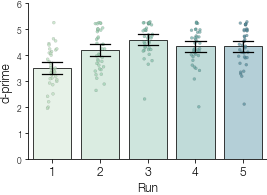

In [6]:
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    res.reset_index().query('part == 1'),
    x='run',
    y='dprime',
    dodge=True,
    legend=False,
    point_kind='strip',
    ax=ax,
)
ax.set(ylim=(0, 6), xlabel='Run', ylabel="d-prime")
fig.savefig(os.path.join(fig_dir, 'part1_dprime.pdf'));

In [7]:
part1 = res.query('part == 1')
runs = part1.pivot(index='subject', columns='run', values='dprime')
pg.rm_anova(part1, dv='dprime', within='run', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,run,4,144,31.894377,5.053736e-19,0.469765,0.815958


In [8]:
# compare performance on adjacent runs
labels = [f'{r + 1} - {r}' for r in range(1, 5)]
tab_list = []
for r in range(1, 5):
    t = pg.ttest(runs[r + 1], runs[r], paired=True)
    diff = runs[r + 1] - runs[r]
    t['mean'] = diff.mean()
    t['sem'] = diff.sem()
    tab_list.append(t)
tab = pd.concat(tab_list, axis=0, ignore_index=True)
tab.index = labels
tab['pcor'] = pg.multicomp(tab['p-val'].to_numpy(), method='fdr_bh')[1]
tab

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,mean,sem,pcor
2 - 1,6.321663,36,two-sided,2.588415e-07,"[0.47, 0.91]",0.913540,6.076e+04,0.999713,0.688365,0.108890,0.000001
3 - 2,3.989797,36,two-sided,3.105943e-04,"[0.2, 0.61]",0.591043,88.912,0.937945,0.402626,0.100914,0.000621
4 - 3,-3.244320,36,two-sided,2.543796e-03,"[-0.43, -0.1]",0.411381,13.703,0.682675,-0.265563,0.081855,0.003392
5 - 4,0.247058,36,two-sided,8.062665e-01,"[-0.15, 0.19]",0.029677,0.182,0.053546,0.020866,0.084458,0.806266


## Part 2

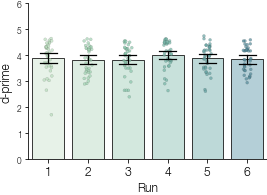

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    res.reset_index().query('part == 2'),
    x='run',
    y='dprime',
    dodge=True,
    legend=False,
    point_kind='strip',
    ax=ax,
)
ax.set(ylim=(0, 6), xlabel='Run', ylabel="d-prime")
fig.savefig(os.path.join(fig_dir, 'part2_dprime.pdf'));

In [10]:
part2 = res.query('part == 2')
pg.rm_anova(part2, dv='dprime', within='run', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,run,5,180,1.125039,0.348718,0.030304,0.807415
